### Análisis y Procesamiento de Señales
# TS5: Estimación espectral: Ancho de banda de señales reales
#### Tatiana Galansky, Guadalupe Cura


### INTRODUCCIÓN TEÓRICA
La Densidad Espectral de Potencia (PSD), denotada como $P_{XX}(\omega)$, es una herramienta para realizar un análisis espectral de diferentes señales. Teóricamente, la PSD de un proceso aleatorio se define como la Transformada de Fourier de Tiempo Discreto (DTFT) de su función de autocorrelación, $r_{XX}[l]$. 

$$\hat{P}{XX} (\omega) = \sum_{l=-\infty}^{\infty} r_{XX}[l]e^{-j\omega l}$$

Sin embargo, en aplicaciones prácticas se dispone únicamente de un número finito de muestras, lo que obliga a emplear técnicas de estimación espectral. En este trabajo se consideran tres métodos no paramétricos de uso frecuente: el periodograma modificado, el método de Welch y el método de Blackman-Tukey.

El periodograma modificado es una versión del periodograma clásico y se obtiene calculando el cuadrado de la magnitud de la DTFT de la secuencia de $N$ puntos, $x_N[n]$, previamente multiplicada por una ventana $w_N[n]$. El uso de ventanas, como las de Hamming, Hann o Blackman, es necesario para reducir la propagación espectral (spectral spread) y el desparramo, aunque esto conlleva un ensanchamiento del lóbulo principal del espectro. 

$$P_M (\omega;N) \triangle = \frac{\left| \sum_{n=0}^{N-1} x[n]w_N[n]e^{-j\omega n} \right|^2}{\sum_{n=0}^{N-1} w_N^2[n]}, \quad -\pi \le \omega < \pi$$

El método de Welch, en cambio, mejora la estimación reduciendo la varianza. Para ello divide la señal en segmentos superpuestos, calcula el periodograma de cada uno y promedia los resultados, generando un compromiso entre resolución espectral y estabilidad estadística. 

$$P_W (\omega;L;D;M) = \frac{1}{M} \sum_{m=0}^{M-1} \frac{\left| \sum_{n=0}^{L-1} x[n+mD]w_L[n]e^{-j\omega n} \right|^2}{\sum_{n=0}^{L-1} w_L^2[n]}$$

Por último, el método de Blackman-Tukey parte de la definición teórica de la PSD, ya que consiste en estimar la función de autocorrelación de la señal, ventaneando de forma tal que se tome en cuenta solamente la parte de la señal de autocorrelación con mayor solapamiento, y aplicar sobre ella una Transformada de Fourier.

$$P_{BT}(\omega) = \sum_{l=-(L-1)}^{L-1} \hat{r}_{XX}[l] w_L[l] e^{-j\omega l}$$

Una vez obtenida la estimación espectral, se procede al cálculo del ancho de banda de cada señal. El ancho de banda corresponde al rango de frecuencias en el que se concentra la mayor parte de la energía de la señal, siendo un parámetro fundamental para su caracterización. Este aspecto está directamente relacionado con los requisitos de muestreo: de acuerdo con el teorema de Nyquist, para reconstruir una señal sin pérdida de información es necesario muestrearla a una frecuencia $f_s$ que sea al menos el doble de su ancho de banda máximo $f_b$ ($f_s > 2f_b$).

La estimación del ancho de banda resulta especialmente relevante en el análisis de señales biológicas, como ECG y PPG, así como en señales acústicas de audio. No solo permite determinar si la adquisición de las señales se realizó correctamente, sino que también orienta el diseño de filtros adecuados para etapas posteriores de procesamiento.



### ANÁLISIS Y DESARROLLO

Para comenzar el desarrollo de la tarea semanal, se utilizó un archivo de electrocardiograma proporcionado por la materia, con el objetivo de calcular la densidad espectral de potencia mediante diferentes métodos y posteriormente comparar los resultados.
Como primer paso, se calculó la densidad espectral de potencia utilizando el método de Welch, el cual se encuentra implementado en la función correspondiente de la librería signal de scipy.


In [1]:
import numpy as np
from scipy import signal as sig

import matplotlib.pyplot as plt
   
import scipy.io as sio
from scipy.io.wavfile import write

##################
## ECG sin ruido
##################

ecg_one_lead = np.load('ecg_sin_ruido.npy')


# parametros
fs_ecg = 1000 # Hz
N_ecg = len(ecg_one_lead)
df_ecg = fs_ecg / N_ecg
nn_ecg = np.arange(N_ecg)
ff_ecg = np.arange(N_ecg) * df_ecg

cant_promedio = 15
nperseg = N_ecg // cant_promedio

f_welch_ecg, Pxx_welch_ecg = sig.welch(ecg_one_lead, fs = fs_ecg, window = 'hamming', nperseg = nperseg, nfft = 3*nperseg)


Como se observa en el código, la función utilizada para calcular la densidad espectral de potencia mediante el método de Welch requiere definir la ventana que se aplicará al segmento de datos. En este caso, se empleó una ventana de Hamming, y se ajustaron los parámetros de promediado y resolución espectral en función de los resultados obtenidos con esta configuración.

Cabe destacar que, si se modifica el tipo de ventana, es probable que sea necesario ajustar la cantidad de promedios y el número de muestras empleadas en el zero padding, con el fin de mantener la resolución espectral y el nivel de suavizado deseados en la estimación final.

Finalmente, dentro del análisis mediante el método de Welch, se procedió a estimar el ancho de banda de la señal.

Para ello, se definieron dos límites de frecuencia, uno inferior y otro superior, de manera que el área comprendida entre ambos contuviera aproximadamente el 99% de la energía total del espectro.


In [3]:
def ancho_de_banda(f, Pxx, target_energy=0.99):
    df = f[1] - f[0]
    
    # Normalizar PSD
    Pxx_norm = Pxx / np.sum(Pxx * df)
    Pxx_cum = np.cumsum(Pxx_norm * df)
    
    # Encontrar los percentiles
    # Límite inferior: percentil 0.5%
    # Límite superior: percentil 99.5%
    lower_idx = np.where(Pxx_cum >= (1 - target_energy)/2)[0]
    upper_idx = np.where(Pxx_cum >= 1 - (1 - target_energy)/2)[0]
    
    if len(lower_idx) > 0 and len(upper_idx) > 0:
        i = lower_idx[0]
        j = upper_idx[0]
        bw = f[j] - f[i]
        return bw, f[i], f[j], i, j
    else:
        # Fallback: usar todo el rango
        return f[-1] - f[0], f[0], f[-1], 0, len(f)-1


BW_welch_ecg, f_welch_ecg_inf, f_welch_ecg_sup, i_welch_ecg, j_welch_ecg = ancho_de_banda(f_welch_ecg, Pxx_welch_ecg)


Este procedimiento se repitió pero esta vez utilizando el periodograma como método de estimación. 

In [4]:
# con periodograma

ecg_one_lead = np.load('ecg_sin_ruido.npy')

# parámetros
fs_ecg = 1000  # Hz
N_ecg = len(ecg_one_lead)

# Calcular el periodograma
f_periodograma_ecg, Pxx_periodograma_ecg = sig.periodogram(ecg_one_lead, fs=fs_ecg, window='hamming', nfft=2*N_ecg)

BW_periodograma_ecg, f_periodograma_ecg_inf, f_periodograma_ecg_sup, i_periodograma_ecg, j_periodograma_ecg = ancho_de_banda(f_periodograma_ecg, Pxx_periodograma_ecg)


Por último se graficó la densidad espectral obtenida por ambos métodos para así poder hacer una comparación gráfica.

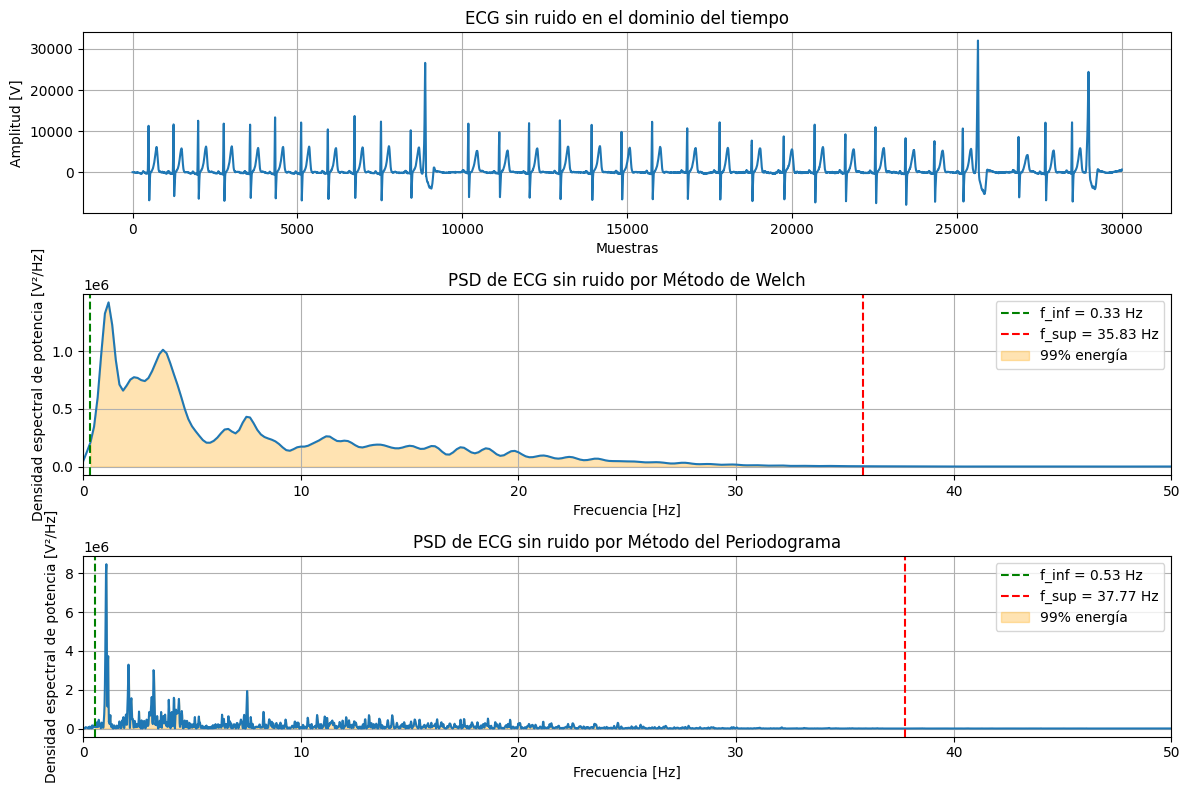

In [5]:
# Grafico comparativo de todos los metodos
fig, axs = plt.subplots(3, 1, figsize=(12,8))

axs[0].plot(ecg_one_lead)
axs[0].set_title('ECG sin ruido en el dominio del tiempo')
axs[0].set_ylabel("Amplitud [V]")
axs[0].set_xlabel('Muestras')
axs[0].grid(True)

axs[1].plot(f_welch_ecg, Pxx_welch_ecg)
axs[1].axvline(f_welch_ecg_inf, color='g', linestyle='--', label=f'f_inf = {f_welch_ecg_inf:.2f} Hz')
axs[1].axvline(f_welch_ecg_sup, color='r', linestyle='--', label=f'f_sup = {f_welch_ecg_sup:.2f} Hz')
axs[1].fill_between(f_welch_ecg[i_welch_ecg:j_welch_ecg+1], Pxx_welch_ecg[i_welch_ecg:j_welch_ecg+1], color='orange', alpha=0.3, label='99% energía')
axs[1].set_title('PSD de ECG sin ruido por Método de Welch')
axs[1].set_ylabel("Densidad espectral de potencia [V²/Hz]")
axs[1].set_xlabel('Frecuencia [Hz]')
axs[1].grid(True)
axs[1].set_xlim(0,50)
axs[1].legend()

axs[2].plot(f_periodograma_ecg, Pxx_periodograma_ecg)
axs[2].axvline(f_periodograma_ecg_inf, color='g', linestyle='--', label=f'f_inf = {f_periodograma_ecg_inf:.2f} Hz')
axs[2].axvline(f_periodograma_ecg_sup, color='r', linestyle='--', label=f'f_sup = {f_periodograma_ecg_sup:.2f} Hz')
axs[2].fill_between(f_periodograma_ecg[i_periodograma_ecg:j_periodograma_ecg+1], Pxx_periodograma_ecg[i_periodograma_ecg:j_periodograma_ecg+1], color='orange', alpha=0.3, label='99% energía')
axs[2].set_title('PSD de ECG sin ruido por Método del Periodograma')
axs[2].set_ylabel("Densidad espectral de potencia [V²/Hz]")
axs[2].set_xlabel('Frecuencia [Hz]')
axs[2].grid(True)
axs[2].set_xlim(0,50)
axs[2].legend()

plt.tight_layout()


Al comparar las estimaciones de la densidad espectral de potencia (PSD) obtenidas mediante el método de Welch y el método del Periodograma, se observa una diferencia notable en la escala del eje vertical. Esta diferencia surge de las características propias de cada método y de los parámetros empleados en la estimación espectral.

El método de Welch realiza un promediado de varios periodogramas parciales obtenidos de segmentos solapados de la señal. Este proceso de promediado reduce la varianza de la estimación, suaviza las irregularidades del espectro y tiende a disminuir la amplitud de los picos de potencia. En consecuencia, la curva obtenida con Welch presenta una apariencia más estable y con amplitudes menores, aunque conserva la misma energía total distribuida a lo largo del espectro.

Por el contrario, el método del Periodograma calcula la densidad espectral directamente a partir de la transformada de Fourier de toda la señal, sin realizar promediado alguno. Esto produce una estimación con alta varianza, donde los picos espectrales aparecen más marcados y con amplitudes significativamente mayores. El resultado es, como se observa en el gráfico, una representación más sensible a las fluctuaciones instantáneas de potencia. Esto se puede ver en los picos característicos del gráfico.

Por otro lado, mediante ambos métodos se obtuvo un ancho de banda similar y coherente, lo que indica que por más de que las amplitudes en frecuencia no puedan ser comparadas directamente, otros parámetros como la energía y el ancho de banda se mantienen cercanos sin importar el método utilizado. 


En segundo lugar se analizó una señal de pletismografía (PPG) registrada en reposo de un estudiante de la materia. Para esta señal se realizó nuevamente el análisis espectral utilizando los métodos de Welch y del periodograma modificado, y, además, el método de Blackman-Tukey.



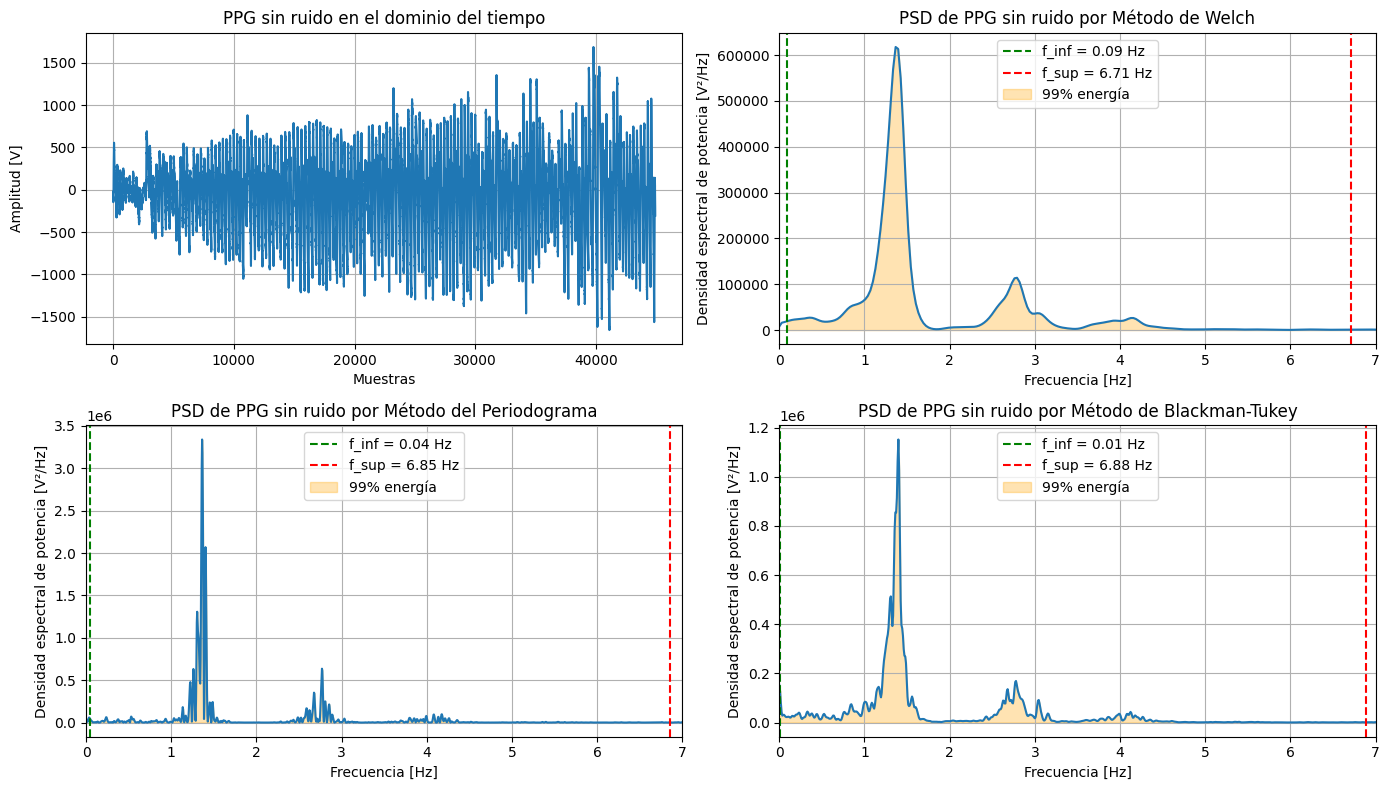

In [6]:
#%%
##################
## PPG sin ruido
##################

ppg = np.load('ppg_sin_ruido.npy')

# parametros
fs_ppg = 400 # Hz
N_ppg = len(ppg)
df_ppg = fs_ppg / N_ppg
nn_ppg = np.arange(N_ppg)
ff_ppg = np.arange(N_ppg) * df_ppg

cant_promedio_ppg = 10 
nperseg = N_ppg // cant_promedio_ppg

f_welch_ppg, Pxx_welch_ppg = sig.welch(ppg, fs = fs_ppg, window = 'blackmanharris', nperseg = nperseg, nfft = 3*nperseg)

BW_welch_ppg, f_welch_ppg_inf, f_welch_ppg_sup, i_welch_ppg, j_welch_ppg = ancho_de_banda(f_welch_ppg, Pxx_welch_ppg)


# con periodograma

# Calcular el periodograma
f_periodograma_ppg, Pxx_periodograma_ppg = sig.periodogram(x=ppg, fs=fs_ppg, window='blackmanharris', nfft=2*N_ppg)

BW_periodograma_ppg, f_periodograma_ppg_inf, f_periodograma_ppg_sup, i_periodograma_ppg, j_periodograma_ppg = ancho_de_banda(f_periodograma_ppg, Pxx_periodograma_ppg)

# Método Blackman-Tukey 
def blackman_tukey(signal, fs, max_lag=None):
    N = len(signal)
    if max_lag is None:
        max_lag = N // 4  # Lag máximo recomendado: N/4
    
    # Calcular autocorrelación SIN NORMALIZAR
    autocorr = sig.correlate(signal, signal, mode='full')
    #lags = sig.correlation_lags(len(signal), len(signal), mode='full')
    
    # Extraer la parte central (lags positivos y negativos)
    mid_point = len(autocorr) // 2
    autocorr_centered = autocorr[mid_point - max_lag:mid_point + max_lag + 1]
    
    # Aplicar ventana (Bartlett recomendada para Blackman-Tukey)
    window = sig.windows.bartlett(len(autocorr_centered))
    autocorr_windowed = autocorr_centered * window
    
    # Calcular PSD
    nfft = max(1024, 2 * len(autocorr_windowed))
    f_bt = np.fft.fftfreq(nfft, 1/fs)[:nfft//2]
    Pxx_bt = np.fft.fft(autocorr_windowed, n=nfft)[:nfft//2]
    Pxx_bt = np.abs(Pxx_bt) * (2 / (fs * N))  # Escalado correcto
    
    return f_bt, Pxx_bt

# Usar la función corregida
f_bt_ppg, Pxx_bt_ppg = blackman_tukey(ppg, fs_ppg, max_lag=len(ppg)//4)

BW_bt_ppg, f_bt_ppg_inf, f_bt_ppg_sup, i_bt_ppg, j_bt_ppg = ancho_de_banda(f_bt_ppg, Pxx_bt_ppg)


# Grafico comparativo de todos los metodos
fig, axs = plt.subplots(2, 2, figsize=(14,8))

axs[0,0].plot(ppg)
axs[0,0].set_title('PPG sin ruido en el dominio del tiempo')
axs[0,0].set_ylabel("Amplitud [V]")
axs[0,0].set_xlabel('Muestras')
axs[0,0].grid(True)

axs[0,1].plot(f_welch_ppg, Pxx_welch_ppg)
axs[0,1].axvline(f_welch_ppg_inf, color='g', linestyle='--', label=f'f_inf = {f_welch_ppg_inf:.2f} Hz')
axs[0,1].axvline(f_welch_ppg_sup, color='r', linestyle='--', label=f'f_sup = {f_welch_ppg_sup:.2f} Hz')
axs[0,1].fill_between(f_welch_ppg[i_welch_ppg:j_welch_ppg+1], Pxx_welch_ppg[i_welch_ppg:j_welch_ppg+1], color='orange', alpha=0.3, label='99% energía')
axs[0,1].set_title('PSD de PPG sin ruido por Método de Welch')
axs[0,1].set_ylabel("Densidad espectral de potencia [V²/Hz]")
axs[0,1].set_xlabel('Frecuencia [Hz]')
axs[0,1].grid(True)
axs[0,1].set_xlim(0,7)
axs[0,1].legend()

axs[1,0].plot(f_periodograma_ppg, Pxx_periodograma_ppg)
axs[1,0].axvline(f_periodograma_ppg_inf, color='g', linestyle='--', label=f'f_inf = {f_periodograma_ppg_inf:.2f} Hz')
axs[1,0].axvline(f_periodograma_ppg_sup, color='r', linestyle='--', label=f'f_sup = {f_periodograma_ppg_sup:.2f} Hz')
axs[1,0].fill_between(f_periodograma_ppg[i_periodograma_ppg:j_periodograma_ppg+1], Pxx_periodograma_ppg[i_periodograma_ppg:j_periodograma_ppg+1], color='orange', alpha=0.3, label='99% energía')
axs[1,0].set_title('PSD de PPG sin ruido por Método del Periodograma')
axs[1,0].set_ylabel("Densidad espectral de potencia [V²/Hz]")
axs[1,0].set_xlabel('Frecuencia [Hz]')
axs[1,0].grid(True)
axs[1,0].set_xlim(0,7)
axs[1,0].legend()

axs[1,1].plot(f_bt_ppg, Pxx_bt_ppg)
axs[1,1].axvline(f_bt_ppg_inf, color='g', linestyle='--', label=f'f_inf = {f_bt_ppg_inf:.2f} Hz')
axs[1,1].axvline(f_bt_ppg_sup, color='r', linestyle='--', label=f'f_sup = {f_bt_ppg_sup:.2f} Hz')
axs[1,1].fill_between(f_bt_ppg[i_bt_ppg:j_bt_ppg+1], Pxx_bt_ppg[i_bt_ppg:j_bt_ppg+1], color='orange', alpha=0.3, label='99% energía')
axs[1,1].set_title('PSD de PPG sin ruido por Método de Blackman-Tukey')
axs[1,1].set_ylabel("Densidad espectral de potencia [V²/Hz]")
axs[1,1].set_xlabel('Frecuencia [Hz]')
axs[1,1].grid(True)
axs[1,1].set_xlim(0,7)
axs[1,1].legend()

plt.tight_layout()



El periodograma modificado ofrece buena resolución en frecuencia, mostrando picos agudos y detallados, pero con una varianza espectral mucho mayor. El método de Welch suaviza la PSD al promediar varios periodogramas de segmentos solapados, reduciendo la varianza a costa de una menor resolución, por lo que en la práctica se buscó optimizar esa relación de compromiso variando la cantidad de promedios. En este caso, la banda de energía se mantiene coherente con el periodograma. Por su parte, el método de Blackman-Tukey genera un espectro más filtrado y compacto, ya que la ventana sobre la autocorrelación atenúa componentes débiles y suaviza el espectro.

Luego se realizó el análisis para tres señales de audio diferentes. 


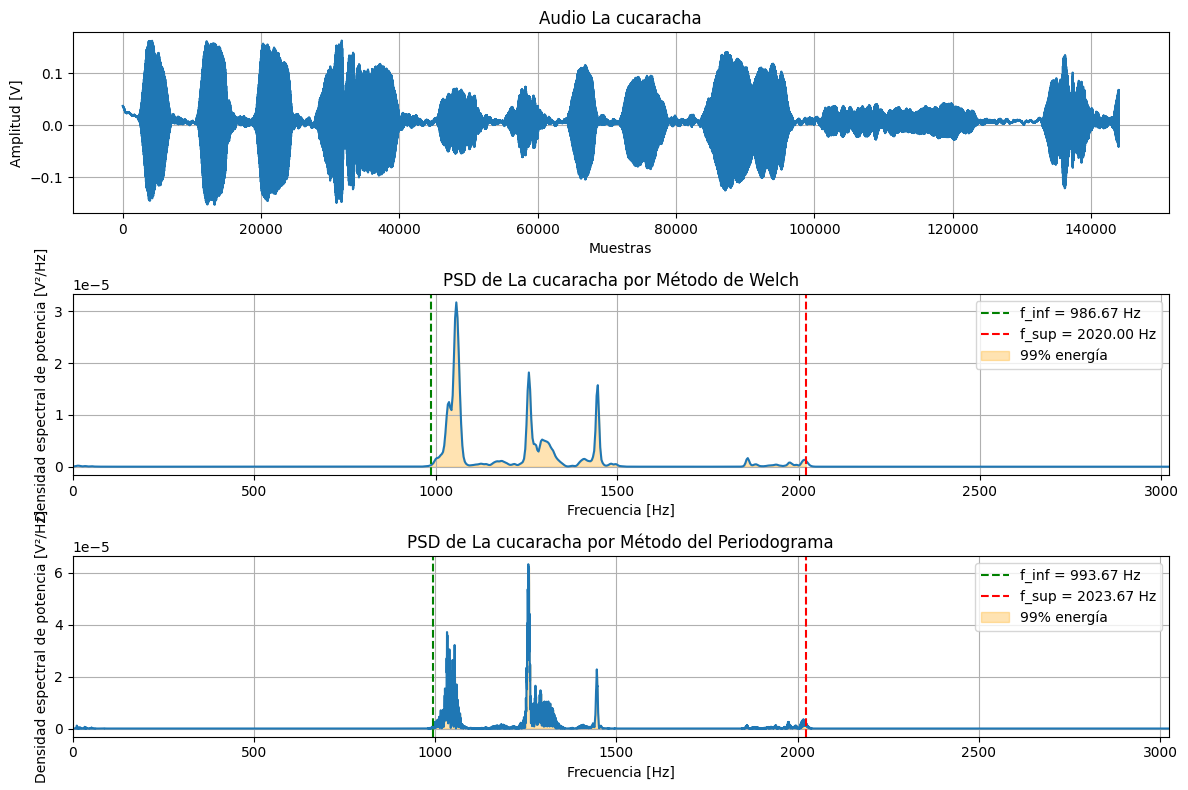

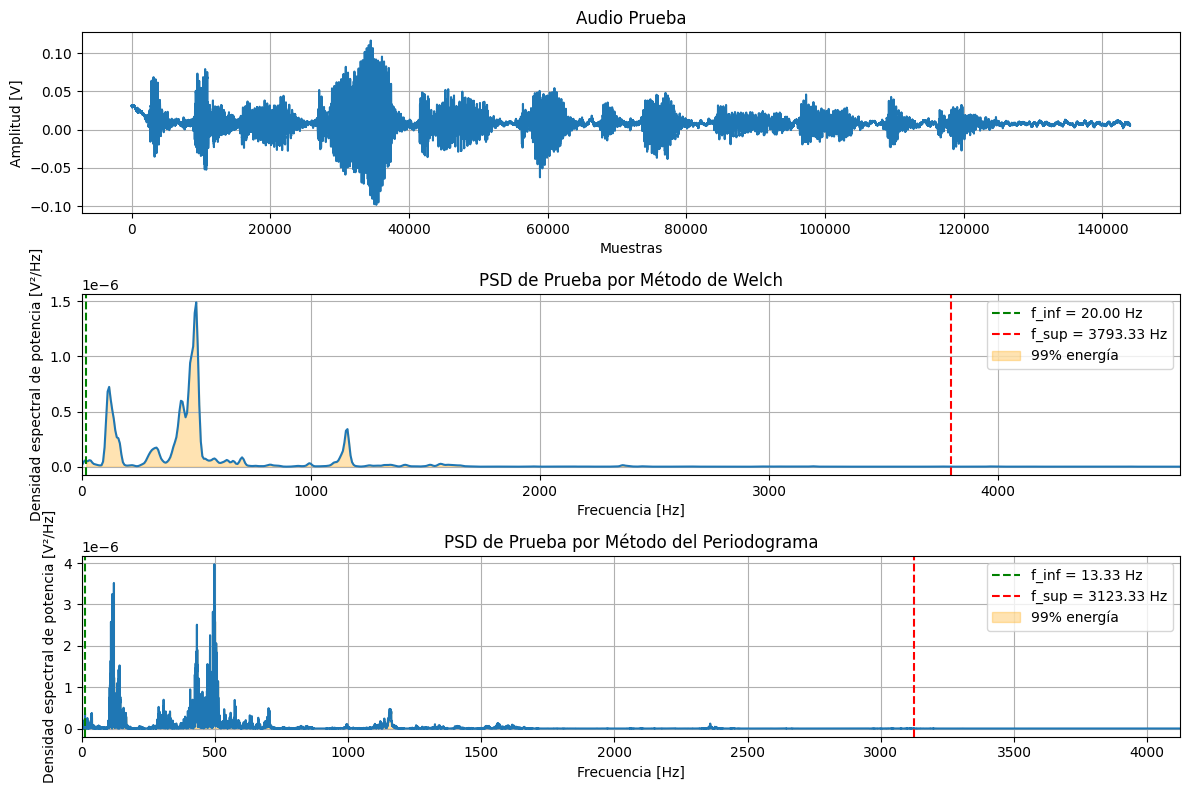

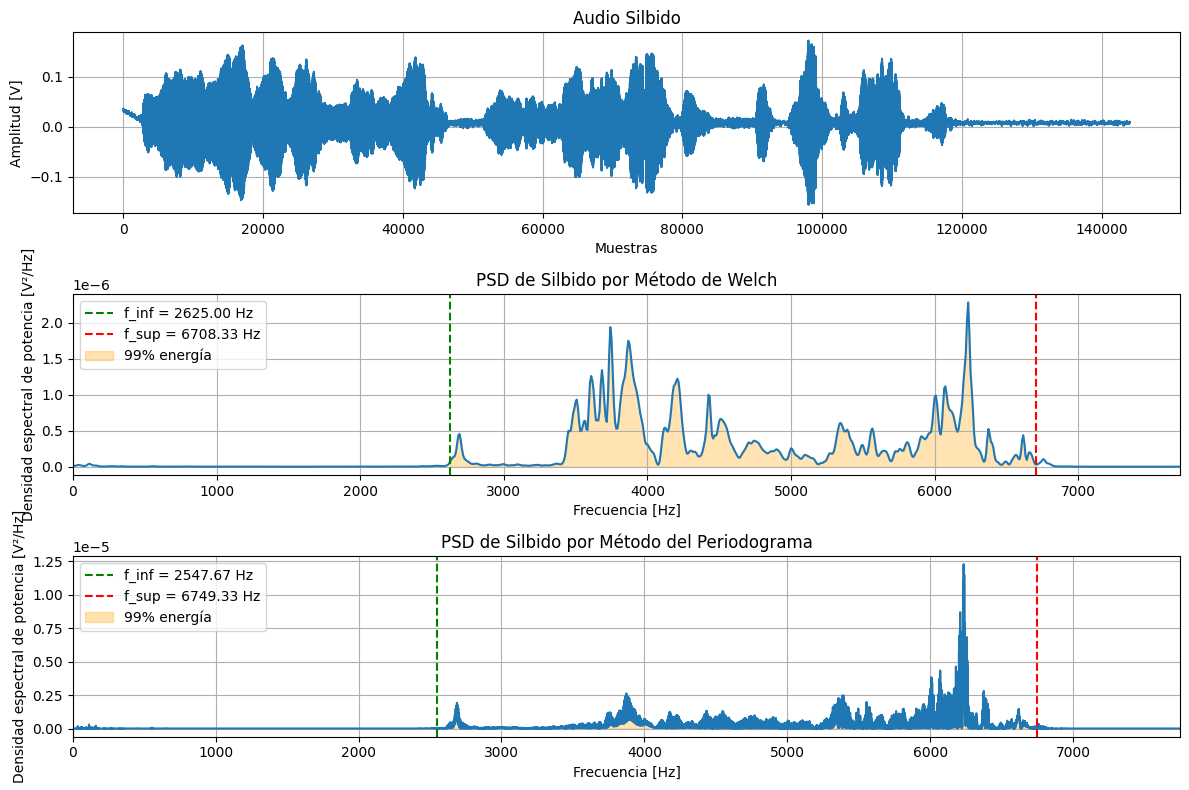

In [7]:
#%%
def analisis_espectral(fs_audio, wav_data, promedios, nombre):
    
    nperseg = wav_data.shape[0] // promedios
    
    f_welch, Pxx_welch = sig.welch(x=wav_data, fs=fs_audio, window = 'hamming', nperseg = nperseg, nfft = 2*nperseg)
    
    BW_welch, f_welch_inf, f_welch_sup, i_welch, j_welch = ancho_de_banda(f_welch, Pxx_welch)
    
    # Calcular el periodograma
    f_periodograma, Pxx_periodograma = sig.periodogram(x=wav_data, fs=fs_audio, window='hamming')

    BW_periodograma, f_periodograma_inf, f_periodograma_sup, i_periodograma, j_periodograma = ancho_de_banda(f_periodograma, Pxx_periodograma)
    
    # Grafico comparativo de todos los metodos
    fig, axs = plt.subplots(3, 1, figsize=(12,8))

    axs[0].plot(wav_data)
    axs[0].set_title(f'Audio {nombre}')
    axs[0].set_ylabel("Amplitud [V]")
    axs[0].set_xlabel('Muestras')
    axs[0].grid(True)

    axs[1].plot(f_welch, Pxx_welch)
    axs[1].axvline(f_welch_inf, color='g', linestyle='--', label=f'f_inf = {f_welch_inf:.2f} Hz')
    axs[1].axvline(f_welch_sup, color='r', linestyle='--', label=f'f_sup = {f_welch_sup:.2f} Hz')
    axs[1].fill_between(f_welch[i_welch:j_welch+1], Pxx_welch[i_welch:j_welch+1], color='orange', alpha=0.3, label='99% energía')
    axs[1].set_title(f'PSD de {nombre} por Método de Welch')
    axs[1].set_ylabel("Densidad espectral de potencia [V²/Hz]")
    axs[1].set_xlabel('Frecuencia [Hz]')
    axs[1].grid(True)
    axs[1].set_xlim(0,f_welch_sup+1000)
    axs[1].legend()

    axs[2].plot(f_periodograma, Pxx_periodograma)
    axs[2].axvline(f_periodograma_inf, color='g', linestyle='--', label=f'f_inf = {f_periodograma_inf:.2f} Hz')
    axs[2].axvline(f_periodograma_sup, color='r', linestyle='--', label=f'f_sup = {f_periodograma_sup:.2f} Hz')
    axs[2].fill_between(f_periodograma[i_periodograma:j_periodograma+1], Pxx_periodograma[i_periodograma:j_periodograma+1], color='orange', alpha=0.3, label='99% energía')
    axs[2].set_title(f'PSD de {nombre} por Método del Periodograma')
    axs[2].set_ylabel("Densidad espectral de potencia [V²/Hz]")
    axs[2].set_xlabel('Frecuencia [Hz]')
    axs[2].grid(True)
    axs[2].set_xlim(0,f_periodograma_sup+1000)
    axs[2].legend()
    plt.tight_layout()
    
    return BW_welch, BW_periodograma, f_welch_inf, f_periodograma_inf, f_welch_sup, f_periodograma_sup

# Lectura de audio
# Cargar el archivo CSV como un array de NumPy
fs_audio1, wav_data1 = sio.wavfile.read('la cucaracha.wav')
fs_audio2, wav_data2 = sio.wavfile.read('prueba psd.wav')
fs_audio3, wav_data3 = sio.wavfile.read('silbido.wav')

BW_welch_audio1, BW_periodograma_audio1, f_welch_audio1_inf, f_periodograma_audio1_inf, f_welch_audio1_sup, f_periodograma_audio1_sup=analisis_espectral(fs_audio = fs_audio1, wav_data=wav_data1, promedios=20, nombre='La cucaracha')
BW_welch_audio2, BW_periodograma_audio2, f_welch_audio2_inf, f_periodograma_audio2_inf, f_welch_audio2_sup, f_periodograma_audio2_sup=analisis_espectral(fs_audio = fs_audio2, wav_data=wav_data2, promedios=40, nombre='Prueba')
BW_welch_audio3, BW_periodograma_audio3, f_welch_audio3_inf, f_periodograma_audio3_inf, f_welch_audio3_sup, f_periodograma_audio3_sup=analisis_espectral(fs_audio = fs_audio3, wav_data=wav_data3, promedios=50, nombre='Silbido')



De la misma manera, se observa que el método del periodograma modificado presenta mayor varianza y mayor resolución espectral que el método de Welch, y que ambos métodos presentan bandas de energía similares para todos los audios. 


Para realizar una mejor comparación de los métodos, se presentan los resultados en las siguientes tablas.

In [8]:
#%%
def tabla_comparativa(nombre, BW_welch, BW_periodograma, f_welch_inf, f_periodograma_inf, f_welch_sup, f_periodograma_sup):
    print(f"\n{'='*80}")
    print(f"\n{f'TABLA COMPARATIVA DE {nombre}':^80}")
    print(f"{'='*80}")
    print(f"{'Metodo utilizado':>15} {'Ancho de banda [Hz]':<20} {'Límite inferior [Hz]':<20} {'Límite superior [Hz]':<20}")
    print(f"{'-'*80}")
    
    print(f"{'Welch':>15} {BW_welch:>20.2f} {f_welch_inf:>20.2f} {f_welch_sup:>20.2f}")
    print(f"{'Periodograma':>15} {BW_periodograma:>20.2f} {f_periodograma_inf:>20.2f} {f_periodograma_sup:>20.2f}")


tabla_comparativa('ECG', BW_welch_ecg, BW_periodograma_ecg, f_welch_ecg_inf, f_periodograma_ecg_inf, f_welch_ecg_sup, f_periodograma_ecg_sup)
tabla_comparativa('PPG', BW_welch_ppg, BW_periodograma_ppg, f_welch_ppg_inf, f_periodograma_ppg_inf, f_welch_ppg_sup, f_periodograma_ppg_sup)
tabla_comparativa('AUDIO LA CUCARACHA', BW_welch_audio1, BW_periodograma_audio1, f_welch_audio1_inf, f_periodograma_audio1_inf, f_welch_audio1_sup, f_periodograma_audio1_sup)
tabla_comparativa('AUDIO PRUEBA', BW_welch_audio2, BW_periodograma_audio2, f_welch_audio2_inf, f_periodograma_audio2_inf, f_welch_audio2_sup, f_periodograma_audio2_sup)
tabla_comparativa('AUDIO SILBIDO', BW_welch_audio3, BW_periodograma_audio3, f_welch_audio3_inf, f_periodograma_audio3_inf, f_welch_audio3_sup, f_periodograma_audio3_sup)




                            TABLA COMPARATIVA DE ECG                            
Metodo utilizado Ancho de banda [Hz]  Límite inferior [Hz] Límite superior [Hz]
--------------------------------------------------------------------------------
          Welch                35.50                 0.33                35.83
   Periodograma                37.23                 0.53                37.77


                            TABLA COMPARATIVA DE PPG                            
Metodo utilizado Ancho de banda [Hz]  Límite inferior [Hz] Límite superior [Hz]
--------------------------------------------------------------------------------
          Welch                 6.62                 0.09                 6.71
   Periodograma                 6.81                 0.04                 6.85


                    TABLA COMPARATIVA DE AUDIO LA CUCARACHA                     
Metodo utilizado Ancho de banda [Hz]  Límite inferior [Hz] Límite superior [Hz]
---------------------------------

Los resultados muestran que los métodos de Welch y de Periodograma producen valores de ancho de banda muy similares para todas las señales analizadas. Las pequeñas diferencias observadas se deben a las propiedades teóricas de cada método.

En las señales biológicas (ECG y PPG), los anchos de banda estimados son bajos (alrededor de 30 Hz y 5 Hz, respectivamente), coherentes con la naturaleza lenta de estas señales. En contraste, las señales acústicas presentan anchos de banda mucho mayores, típicamente entre 1 kHz y 4 kHz, reflejando la presencia de componentes de alta frecuencia.

Es importante notar que los resultados del audio “prueba” muestran una menor coherencia en el valor absoluto del ancho de banda. Una posible explicación es que si esta señal incluye ruido significativo o componentes que se extienden ligeramente más allá del pico principal, la estimación del Periodograma puede ser menos precisa que la de Welch, que promedia estos efectos.

Como ejercicio adicional, se pidió buscar otro tipo de señal y analizarla utilizando los mismos métodos empleados anteriormente.

Para ello, se utilizó una señal de electroencefalograma (EEG), la cual permite detectar la actividad eléctrica del cerebro. A partir de esta señal, se realizó un recorte en la longitud del vector de muestras, con el fin de mantener un rango de datos que no sobrecargara el sistema computacional.


Luego, se aplicaron los mismos métodos y se obtuvieron los gráficos mostrados a continuación:


Opening raw data file C:\Users\tatia\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Longitud de la señal: 41700 muestras
Duración: 277.72 segundos
Señal limitada a 1500 muestras
Duración de la señal limitada: 9.99 segundos
nperseg = 500
Resolución frecuencial: 0.3003 Hz
Número de puntos en el espectro: 251

COMPARACIÓN DE ANCHOS DE BANDA - LOS TRES MÉTODOS
MÉTODO WELCH:
  Límite inferior: 0.0000 Hz
  Límite superior: 38.1391 Hz
  Ancho de banda:  38.1391 Hz

MÉTODO PERIODOGRAMA:
  Límite inferior: 0.3003 Hz
  Límite superior: 38.1391 Hz
  Ancho de banda:  37.8387 Hz

MÉTODO BLACKMAN-TUKEY:
  Límite inferior: 0.0000 Hz
  Límite superior: 37.8883 Hz
  Ancho de banda:  3

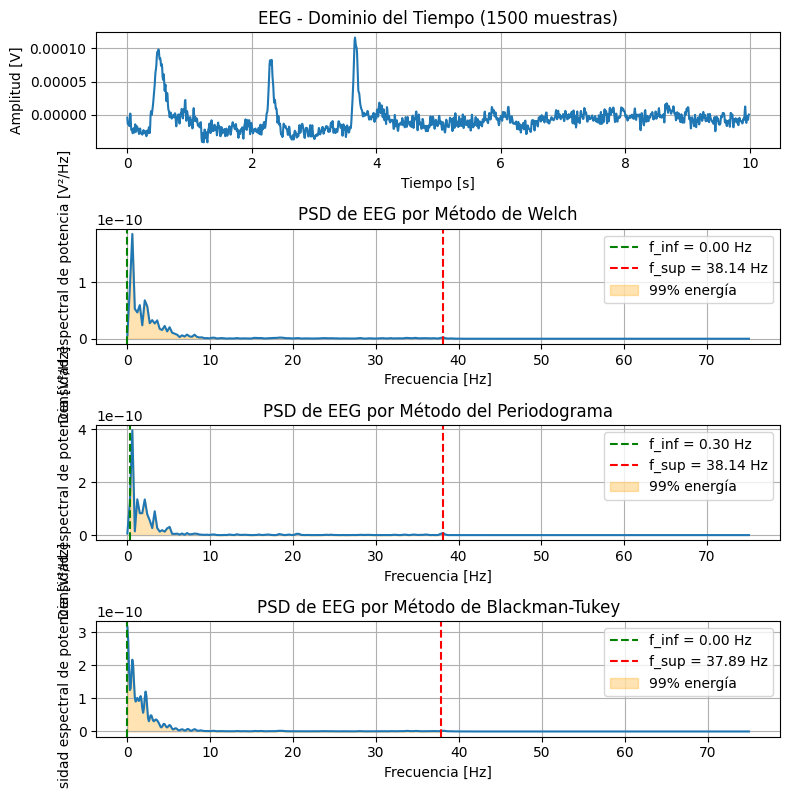

In [9]:
#pip install mne

#%% BONUS

import mne


# Cargar el dataset de ejemplo
data_path = mne.datasets.sample.data_path()
raw_file = data_path / 'MEG' / 'sample' / 'sample_audvis_filt-0-40_raw.fif'
raw = mne.io.read_raw_fif(raw_file, preload=True)

# Extraer datos EEG - UN SOLO CANAL
data, times = raw.get_data(picks=['EEG 001'], return_times=True)
fs = raw.info['sfreq']  # Frecuencia de muestreo

print(f"Longitud de la señal: {len(data[0])} muestras")
print(f"Duración: {len(data[0])/fs:.2f} segundos")

# LIMITAR LA SEÑAL A LAS PRIMERAS 1500 MUESTRAS
eeg = data[0][:1500]
times_limited = times[:1500]

print(f"Señal limitada a {len(eeg)} muestras")
print(f"Duración de la señal limitada: {len(eeg)/fs:.2f} segundos")

# CALCULAR WELCH UNA SOLA VEZ CON PARÁMETROS OPTIMIZADOS
cantPromedios = 3

# Usar la longitud temporal de la señal limitada (eeg)
nperseg = len(eeg) // cantPromedios
print(f'nperseg = {nperseg}')

nfft = 1 * nperseg  # Zero-padding para mejor resolución frecuencial

# Aplicar Welch UNA VEZ con los parámetros optimizados usando la señal limitada
f, Pxx = sig.welch(eeg, fs=fs, window='hann', nperseg=nperseg, nfft=nfft)

print(f"Resolución frecuencial: {f[1]-f[0]:.4f} Hz")
print(f"Número de puntos en el espectro: {len(f)}")


# Calcular el ancho de banda con la señal limitada
# Metodo de Welch
BW_welch_eeg, f_welch_eeg_inf, f_welch_eeg_sup, i_welch_eeg, j_welch_eeg  = ancho_de_banda(f, Pxx)

# Calcular el periodograma
f_periodograma_eeg, Pxx_periodograma_eeg = sig.periodogram(eeg, fs=fs, window='hamming', nfft=nfft)

BW_periodograma_eeg, f_periodograma_eeg_inf, f_periodograma_eeg_sup, i_periodograma_eeg, j_periodograma_eeg = ancho_de_banda(f_periodograma_eeg, Pxx_periodograma_eeg)

# Método Blackman-Tukey (basado en la autocorrelación)

f_bt, Pxx_bt = blackman_tukey(eeg, fs, max_lag=len(eeg)//4)

# Calcular ancho de banda para Blackman-Tukey
BW_bt, f_bt_inf, f_bt_sup, i_bt, j_bt = ancho_de_banda(f_bt, Pxx_bt)

#%% RESULTADOS COMPARATIVOS DE LOS TRES MÉTODOS
print(f"\n{'='*80}")
print("COMPARACIÓN DE ANCHOS DE BANDA - LOS TRES MÉTODOS")
print(f"{'='*80}")
print("MÉTODO WELCH:")
print(f"  Límite inferior: {f_welch_eeg_inf:.4f} Hz")
print(f"  Límite superior: {f_welch_eeg_sup:.4f} Hz")
print(f"  Ancho de banda:  {BW_welch_eeg:.4f} Hz")

print("\nMÉTODO PERIODOGRAMA:")
print(f"  Límite inferior: {f_periodograma_eeg_inf:.4f} Hz")
print(f"  Límite superior: {f_periodograma_eeg_sup:.4f} Hz")
print(f"  Ancho de banda:  {BW_periodograma_eeg:.4f} Hz")

print("\nMÉTODO BLACKMAN-TUKEY:")
print(f"  Límite inferior: {f_bt_inf:.4f} Hz")
print(f"  Límite superior: {f_bt_sup:.4f} Hz")
print(f"  Ancho de banda:  {BW_bt:.4f} Hz")
print(f"{'='*80}")

#%% GRÁFICO COMPARATIVO DE TODOS LOS MÉTODOS
fig, axs = plt.subplots(4, 1, figsize=(8,8))

# Señal en el dominio del tiempo
axs[0].plot(times_limited, eeg)
axs[0].set_title('EEG - Dominio del Tiempo (1500 muestras)')
axs[0].set_ylabel("Amplitud [V]")
axs[0].set_xlabel('Tiempo [s]')
axs[0].grid(True)

# Método de Welch
axs[1].plot(f, Pxx)
axs[1].axvline(f_welch_eeg_inf, color='g', linestyle='--', label=f'f_inf = {f_welch_eeg_inf:.2f} Hz')
axs[1].axvline(f_welch_eeg_sup, color='r', linestyle='--', label=f'f_sup = {f_welch_eeg_sup:.2f} Hz')
axs[1].fill_between(f[i_welch_eeg:j_welch_eeg+1], Pxx[i_welch_eeg:j_welch_eeg+1], color='orange', alpha=0.3, label='99% energía')
axs[1].set_title('PSD de EEG por Método de Welch')
axs[1].set_ylabel("Densidad espectral de potencia [V²/Hz]")
axs[1].set_xlabel('Frecuencia [Hz]')
axs[1].grid(True)
#axs[1].set_xlim(0,40)
axs[1].legend()

# Método del Periodograma
axs[2].plot(f_periodograma_eeg, Pxx_periodograma_eeg)
axs[2].axvline(f_periodograma_eeg_inf, color='g', linestyle='--', label=f'f_inf = {f_periodograma_eeg_inf:.2f} Hz')
axs[2].axvline(f_periodograma_eeg_sup, color='r', linestyle='--', label=f'f_sup = {f_periodograma_eeg_sup:.2f} Hz')
axs[2].fill_between(f_periodograma_eeg[i_periodograma_eeg:j_periodograma_eeg+1], Pxx_periodograma_eeg[i_periodograma_eeg:j_periodograma_eeg+1], color='orange', alpha=0.3, label='99% energía')
axs[2].set_title('PSD de EEG por Método del Periodograma')
axs[2].set_ylabel("Densidad espectral de potencia [V²/Hz]")
axs[2].set_xlabel('Frecuencia [Hz]')
axs[2].grid(True)
#axs[2].set_xlim(0,40)
axs[2].legend()

# Método de Blackman-Tukey
axs[3].plot(f_bt, Pxx_bt)
axs[3].axvline(f_bt_inf, color='g', linestyle='--', label=f'f_inf = {f_bt_inf:.2f} Hz')
axs[3].axvline(f_bt_sup, color='r', linestyle='--', label=f'f_sup = {f_bt_sup:.2f} Hz')
axs[3].fill_between(f_bt[i_bt:j_bt+1], Pxx_bt[i_bt:j_bt+1], color='orange', alpha=0.3, label='99% energía')
axs[3].set_title('PSD de EEG por Método de Blackman-Tukey')
axs[3].set_ylabel("Densidad espectral de potencia [V²/Hz]")
axs[3].set_xlabel('Frecuencia [Hz]')
axs[3].grid(True)
#axs[3].set_xlim(0,40)
axs[3].legend()

plt.tight_layout()
plt.show()


Nuevamente, se observa que la longitud y los espectros obtenidos mediante cada método son similares. Sin embargo, el ancho de banda se encuentra desplazado hacia frecuencias más altas de lo esperado. Esto se debe a la presencia de pequeños picos de frecuencia que aparecen gradualmente entre los 10 y 40 Hz, cuya acumulación incrementa el valor del límite superior. Este efecto puede corregirse ajustando los parámetros de cálculo, de modo que los límites se definan para un porcentaje de energía menor al 99%, por ejemplo, el 80%.

### CONCLUSIÓN
Los resultados muestran que cada método posee ventajas y limitaciones específicas: el periodograma modificado ofrece alta resolución espectral pero presenta mayor varianza; el método de Welch reduce significativamente la varianza mediante el promedio de segmentos solapados, a costa de una menor resolución; mientras que el método de Blackman-Tukey produce un espectro más suavizado y compacto debido al filtrado de la autocorrelación.

Se observó que, a pesar de estas diferencias, los métodos de Welch y de periodograma producen valores de ancho de banda coherentes entre sí, especialmente en señales biológicas como ECG y PPG, donde los anchos de banda estimados son bajos y reflejan la naturaleza lenta de estas señales. En señales acústicas, en cambio, los anchos de banda son considerablemente mayores, acorde con la presencia de componentes de alta frecuencia. Las pequeñas discrepancias observadas se atribuyen a las propiedades teóricas de cada método y a la presencia de ruido o componentes fuera del pico principal.

En general, los resultados evidencian que la elección del método depende del compromiso deseado entre resolución espectral y varianza, así como de las características de la señal analizada. La aplicación del mismo análisis a una señal de EEG adicional confirmó la aplicabilidad de estos métodos a diferentes tipos de señales, mostrando la importancia de ajustar parámetros como la longitud de segmentos y ventanas para optimizar la estimación espectral sin comprometer la carga computacional.


### AUTOEVALUACIÓN DEL APRENDIZAJE
Para llevar a cabo la tarea semanal nos juntamos y trabajamos juntas. Usamos inteligencia artificial para emprolijar el código y para poder organizar los gráficos. 


### BIBLIOGRAFÍA
Holton, T. (2021). *Digital Signal Processing: Principles and Applications*. Cambridge University Press.
